### Exercise Sheet 2

#### 2.2 Solving a PDE with TorchPhysics
Use TorchPhysics to solve the following heat equation:

\begin{align*}
{\partial_t} u(x,t) &= \Delta_x u(x,t) &&\text{ on } \Omega\times I, \\
u(x, t) &= u_0 &&\text{ on } \Omega\times \{0\},\\
u(x,t) &= h(t) &&\text{ at } \partial\Omega_{heater}\times I, \\
\nabla_x u(x, t) \cdot \overset{\rightarrow}{n}(x) &= 0 &&\text{ at } (\partial \Omega \setminus \partial\Omega_{heater}) \times I.
\end{align*}

The above system describes an isolated room $\Omega$, with a \\
heater at the wall $\partial\Omega_{Heater} = \{(x, y) | 1\leq x\leq 3, y=4\}$. We set $I=[0, 20]$, $D=1$, the initial temperature to $u_0 = 16$\,\degree C and the temperature of the heater is defined below.

If you are using Google Colab, you first have to install TorchPhysics with the following cell. We recommend first enabling the GPU and then running the cell.

In [1]:
!pip install torchphysics

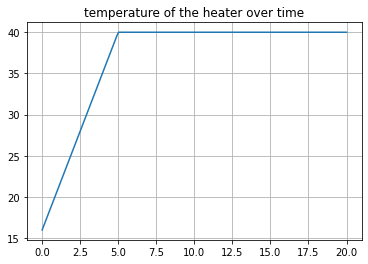

In [2]:
import torch
import torchphysics as tp
import pytorch_lightning as pl
import matplotlib.pyplot as plt

# Here all parameters are defined:
t_min, t_max = 0.0, 20.0
width, height = 5.0, 4.0
D = 1.0
u_0          = 16 # initial temperature
u_heater_max = 40 # maximal temperature of the heater
t_heater_max = 5  # time at which the heater reaches its maximal temperature

# Heater temperature function
def h(t):
    ht = u_0 + (u_heater_max - u_0) / t_heater_max * t
    ht[t>t_heater_max] = u_heater_max
    return ht

# Visualize h(t)
t = torch.linspace(0, 20, 200)
plt.plot(t, h(t))
plt.grid()
plt.title("temperature of the heater over time")

# Number of training points 
N_pde = 15000
N_initial = 5000
N_boundary = 5000

# Training parameters
train_iterations = 5000
learning_rate = 1.e-3

We would recommend trying implementing the following steps by yourself (and/or together with your colleagues). 

But if you need more guidance for TorchPhysics, a heat equation example is shown in this [notebook](https://github.com/TomF98/torchphysics/blob/main/examples/pinn/heat-equation.ipynb).

In [3]:
### TODO: Implement the spaces
X = tp.spaces.R2('x')
T = tp.spaces.R1('t')
U = tp.spaces.R1('u')

### TODO: Define the domain omega and time interval 
Omega = tp.domains.Parallelogram(space=X, origin=[0,0], corner_1=[width,0], corner_2=[0,height])
I     = tp.domains.Interval(space=T, lower_bound=t_min, upper_bound=t_max)

### TODO: Create sampler for inside Omega x I, for the initial condition in Omega x {0} and on the 
###       boundary \partial Omega x I
pde_sampler = tp.samplers.RandomUniformSampler(domain=Omega*I, n_points=N_pde)
initial_sampler = tp.samplers.RandomUniformSampler(domain=Omega*I.boundary_left, n_points=N_initial)
boundary_sampler = tp.samplers.RandomUniformSampler(domain=Omega.boundary*I, n_points=N_boundary)

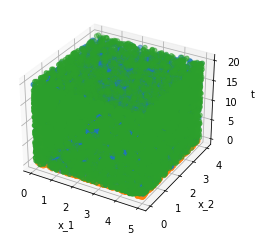

In [4]:
# One can check if the points are sampled in the correct way:
plot = tp.utils.scatter(Omega.space*I.space, pde_sampler, initial_sampler, boundary_sampler)
# Some times the perspective is somewhat strang in the plot, but generally one should see:
# - blue   = points inside the domain Omega x I
# - orange = points at the bottom, for Omega x {0}
# - green  = points at sides, for \partial Omega x I 

In [5]:
### TODO: Create the neural network with 3 hidden layers and 50 neurons each.
model = tp.models.FCN(input_space=X*T, output_space=U, hidden = (50,50,50))

In [6]:
### TODO: Define condition for the PDE:
# Use tp.utils.laplacian and tp.utils.grad to compute all needed derivatives
def pde_residual(u, t, x):
    return tp.utils.laplacian(u, x) - tp.utils.grad(u, t)

pde_condition = tp.conditions.PINNCondition(model, pde_sampler, pde_residual)

In [7]:
### TODO: Define condition for the initial temperature:
def initial_residual(u):
    return u - u_0

initial_condition = tp.conditions.PINNCondition(model, initial_sampler, initial_residual)

In [8]:
### TODO: Define condition for the boundary conditions:
###       Already implemented is a filltering, to determine on what part the points are
###       on the boundary, and the normal vector computation.
###       For the normal derivative use: tp.utils.normal_derivative
def boundary_residual(u, t, x):
    # Create boolean tensor indicating which points x belong to the dirichlet condition (heater location)
    heater_location = (x[:, 0] >= 1) & (x[:, 0] <= 3) & (x[:, 1] >= 3.99)   
    # Normal vectors of the domain Omega
    normal_vectors  = Omega.boundary.normal(x)

    residual = tp.utils.normal_derivative(u, normal_vectors, x)
    residual[heater_location] = (u - h(t))[heater_location]
    return residual

boundary_condition = tp.conditions.PINNCondition(model, boundary_sampler, boundary_residual)

In [38]:
# Start the training
training_conditions = [pde_condition, initial_condition, boundary_condition]
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=learning_rate)
solver = tp.solver.Solver(train_conditions=training_conditions, optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=train_iterations, 
                     logger=False, 
                     enable_checkpointing=False)
trainer.fit(solver) # run the training loop

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 5.4 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.021     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

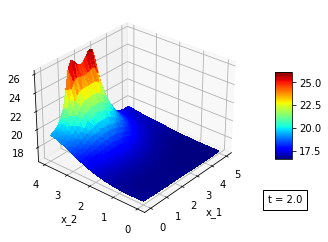

In [49]:
# Plot the solution at some point in time
time_point = 2.0

plot_sampler = tp.samplers.PlotSampler(plot_domain=Omega, n_points=1000, 
                                       data_for_other_variables={'t':time_point}) # <- input that is fixed for the plot
fig = tp.utils.plot(model=model, plot_function=lambda u : u, point_sampler=plot_sampler, angle=[30, 220])

MovieWriter ffmpeg unavailable; using Pillow instead.


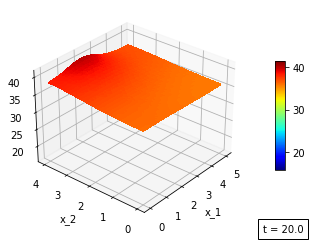

In [ ]:
# We can also animate the solution over time
anim_sampler = tp.samplers.AnimationSampler(Omega, I, 200, n_points=1000)
fig, anim = tp.utils.animate(model, lambda u: u, anim_sampler, ani_speed=10, angle=[30, 220])
anim.save('heat-eq.gif')
# On Google colab you have at the left side a tab with a folder. There you should find the gif and watch it.

In [ ]:
# !wget https://github.com/TomF98/torchphysics/raw/main/examples/workshop/FEMData/Data2_2/time_points.pt
# !wget https://github.com/TomF98/torchphysics/raw/main/examples/workshop/FEMData/Data2_2/space_coords.pt
# !wget https://github.com/TomF98/torchphysics/raw/main/examples/workshop/FEMData/Data2_2/temperature.pt

In [50]:
# Lastly, we can compare the results with an finite element solution:
import numpy as np
fe_time = torch.load("time_points.pt")
fe_space = torch.load("space_coords.pt")
fe_temperature = torch.load("temperature.pt")

in_data = torch.zeros((len(fe_time), len(fe_space), 3))
in_data[:, :, :2] = fe_space
in_data[:, :, 2] = fe_time.repeat(1, len(fe_space))

model_out = model(tp.spaces.Points(in_data, X*T))
print(model_out.as_tensor.shape)
error = torch.abs(model_out.as_tensor - fe_temperature)
print("Max. absolute error between FE and PINN:", torch.max(error))
print("Relative error is:", torch.max(error)/torch.max(fe_temperature))

torch.Size([41, 546, 1])
Max. absolute error between FE and PINN: tensor(7.2122, grad_fn=<MaxBackward1>)
Relative error is: tensor(0.1803, grad_fn=<DivBackward0>)
